# 04 â€” Revenue Prediction / Forecasting

Predict next-week daily revenue using three approaches:
1. **Baseline** â€” 7-day moving average
2. **SARIMA** â€” Seasonal ARIMA from statsmodels
3. **Prophet** â€” Facebook's time-series model

We evaluate each on a held-out test set using MAE, RMSE, and MAPE.

In [1]:
import sys, os, warnings
sys.path.insert(0, os.path.abspath(".."))
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["figure.figsize"] = (14, 5)

# â”€â”€ Load daily revenue â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€
daily = pd.read_csv("../data/warehouse/daily_revenue.csv", parse_dates=["order_date"])
daily = daily.sort_values("order_date").reset_index(drop=True)
daily = daily.set_index("order_date").asfreq("D").fillna(0).reset_index()

print(f"Date range: {daily['order_date'].min().date()} â†’ {daily['order_date'].max().date()}")
print(f"Total days: {len(daily)}")
daily.head()

Date range: 2022-03-01 â†’ 2023-03-31
Total days: 396


,order_date,total_revenue
0,2022-03-01,2785
1,2022-03-02,2318
2,2022-03-03,3714
3,2022-03-04,1711
4,2022-03-05,4798


## Train / Test Split

Hold out the last 30 days as test set.

Train: 366 days  (2022-03-01 â†’ 2023-03-01)
Test:  30 days  (2023-03-02 â†’ 2023-03-31)


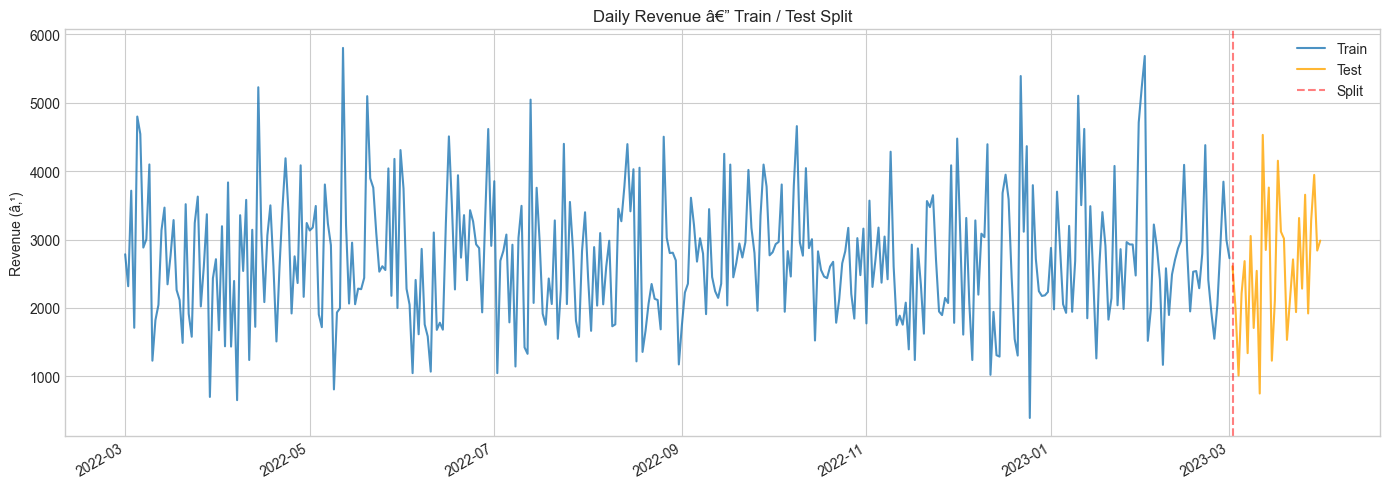

In [2]:
TEST_DAYS = 30

train = daily.iloc[:-TEST_DAYS].copy()
test = daily.iloc[-TEST_DAYS:].copy()

print(f"Train: {len(train)} days  ({train['order_date'].min().date()} â†’ {train['order_date'].max().date()})")
print(f"Test:  {len(test)} days  ({test['order_date'].min().date()} â†’ {test['order_date'].max().date()})")

fig, ax = plt.subplots()
ax.plot(train["order_date"], train["total_revenue"], label="Train", alpha=0.8)
ax.plot(test["order_date"], test["total_revenue"], label="Test", color="orange", alpha=0.8)
ax.axvline(test["order_date"].iloc[0], color="red", linestyle="--", alpha=0.5, label="Split")
ax.set_title("Daily Revenue â€” Train / Test Split")
ax.set_ylabel("Revenue (â‚¹)")
ax.legend()
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

## Helper: Evaluation Metrics

In [3]:
def evaluate(actual, predicted, model_name="Model"):
    """Return MAE, RMSE, MAPE for a forecast."""
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / np.where(actual == 0, 1, actual))) * 100
    print(f"[{model_name}]  MAE={mae:,.0f}  RMSE={rmse:,.0f}  MAPE={mape:.1f}%")
    return {"model": model_name, "MAE": round(mae, 2), "RMSE": round(rmse, 2), "MAPE": round(mape, 2)}

results = []

## Model 1: Baseline â€” 7-Day Moving Average

In [4]:
# Simple baseline: predict each test day as the mean of the last 7 training days
baseline_pred = np.full(len(test), train["total_revenue"].iloc[-7:].mean())
results.append(evaluate(test["total_revenue"].values, baseline_pred, "Baseline (7-day MA)"))

[Baseline (7-day MA)]  MAE=755  RMSE=924  MAPE=40.0%


## Model 2: SARIMA (Seasonal ARIMA)

Uses weekly seasonality (period=7) to capture day-of-week patterns.

In [5]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit SARIMA with weekly seasonality (s=7)
train_series = train.set_index("order_date")["total_revenue"]

sarima = SARIMAX(
    train_series,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 0, 7),
    enforce_stationarity=False,
    enforce_invertibility=False,
)
sarima_fit = sarima.fit(disp=False, maxiter=200)

sarima_forecast = sarima_fit.forecast(steps=TEST_DAYS)
sarima_pred = sarima_forecast.values

results.append(evaluate(test["total_revenue"].values, sarima_pred, "SARIMA(1,1,1)(1,1,0,7)"))
print(f"\nAIC: {sarima_fit.aic:.0f}  BIC: {sarima_fit.bic:.0f}")

[SARIMA(1,1,1)(1,1,0,7)]  MAE=909  RMSE=1,123  MAPE=45.7%

AIC: 5989  BIC: 6005


C:\Users\nagar\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nagar\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


## Model 3: Prophet

Facebook's additive model with built-in trend, weekly & yearly seasonality, and holiday effects.

In [6]:
from prophet import Prophet
import logging
logging.getLogger("cmdstanpy").setLevel(logging.WARNING)

# Prophet expects columns: ds (date), y (value)
prophet_train = train[["order_date", "total_revenue"]].rename(
    columns={"order_date": "ds", "total_revenue": "y"}
)

model = Prophet(
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=True,
    changepoint_prior_scale=0.05,
)
model.fit(prophet_train)

future = model.make_future_dataframe(periods=TEST_DAYS)
forecast = model.predict(future)

prophet_pred = forecast.iloc[-TEST_DAYS:]["yhat"].values
# Clip negative predictions to 0 (revenue can't be negative)
prophet_pred = np.clip(prophet_pred, 0, None)

results.append(evaluate(test["total_revenue"].values, prophet_pred, "Prophet"))

13:48:01 - cmdstanpy - INFO - Chain [1] start processing


13:48:01 - cmdstanpy - INFO - Chain [1] done processing


[Prophet]  MAE=861  RMSE=1,046  MAPE=46.0%


## Prophet Components (Trend + Seasonality)

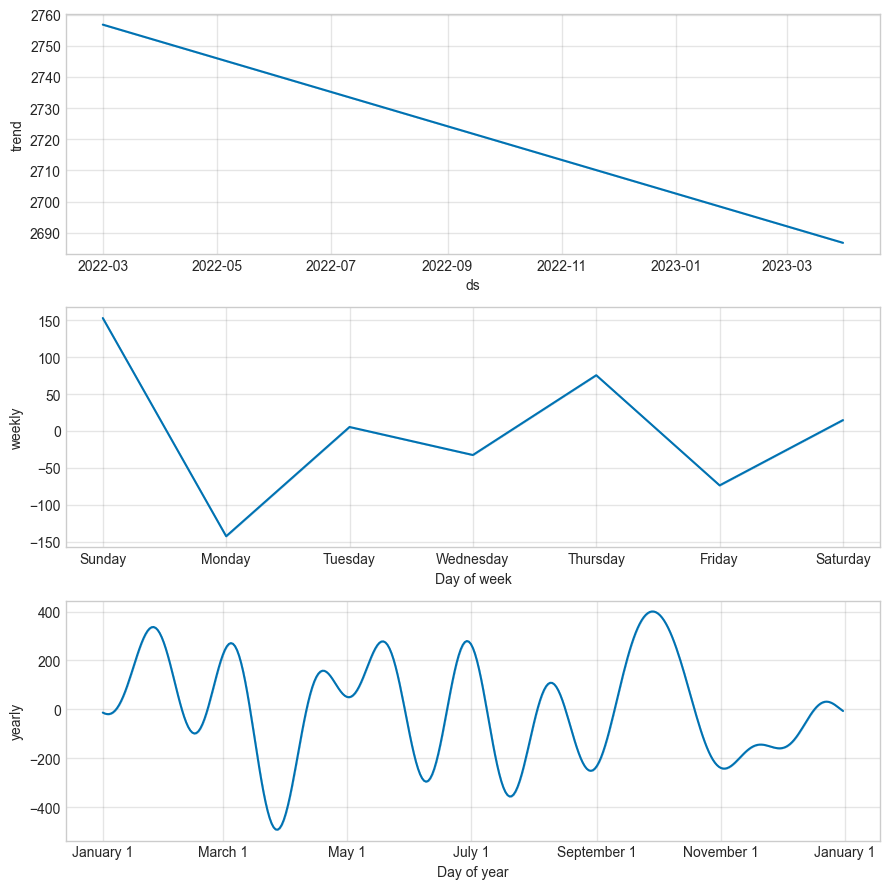

In [7]:
fig = model.plot_components(forecast)
plt.tight_layout()
plt.show()

## Model Comparison â€” All Predictions vs Actual

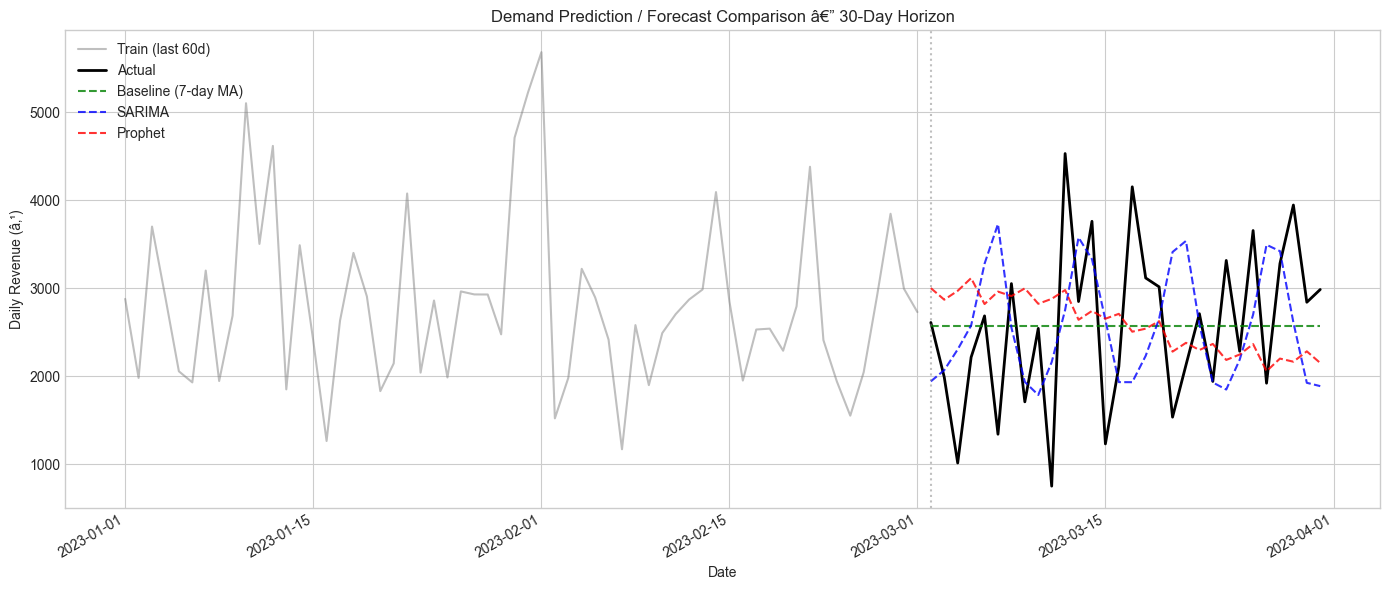

In [8]:
fig, ax = plt.subplots(figsize=(14, 6))

# Last 60 days of training for context
context = train.iloc[-60:]
ax.plot(context["order_date"], context["total_revenue"],
        color="gray", alpha=0.5, label="Train (last 60d)")

# Actual test
ax.plot(test["order_date"], test["total_revenue"],
        color="black", linewidth=2, label="Actual")

# Predictions
ax.plot(test["order_date"], baseline_pred,
        linestyle="--", color="green", alpha=0.8, label="Baseline (7-day MA)")
ax.plot(test["order_date"], sarima_pred,
        linestyle="--", color="blue", alpha=0.8, label="SARIMA")
ax.plot(test["order_date"], prophet_pred,
        linestyle="--", color="red", alpha=0.8, label="Prophet")

ax.axvline(test["order_date"].iloc[0], color="gray", linestyle=":", alpha=0.5)
ax.set_title("Demand Prediction / Forecast Comparison â€” 30-Day Horizon")
ax.set_xlabel("Date")
ax.set_ylabel("Daily Revenue (â‚¹)")
ax.legend(loc="upper left")
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

## Prediction / Forecast Evaluation Summary

   PREDICTION / FORECAST MODEL COMPARISON (30-day horizon)
                 model    MAE    RMSE  MAPE
   Baseline (7-day MA) 754.98  923.94 39.95
               Prophet 860.71 1046.47 45.98
SARIMA(1,1,1)(1,1,0,7) 909.05 1123.02 45.73

Best model: Baseline (7-day MA) (lowest RMSE: 924)


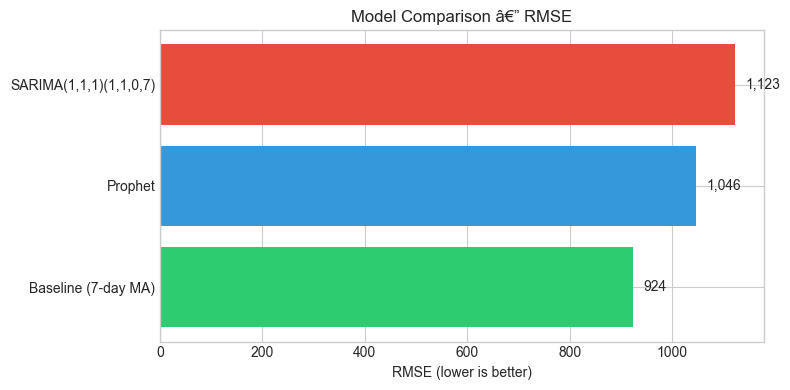

In [9]:
comparison = pd.DataFrame(results)
comparison = comparison.sort_values("RMSE")

print("=" * 60)
print("   PREDICTION / FORECAST MODEL COMPARISON (30-day horizon)")
print("=" * 60)
print(comparison.to_string(index=False))
print("=" * 55)
best = comparison.iloc[0]
print(f"\nBest model: {best['model']} (lowest RMSE: {best['RMSE']:,.0f})")

# Bar chart of RMSE
fig, ax = plt.subplots(figsize=(8, 4))
colors = ["#2ecc71", "#3498db", "#e74c3c"]
ax.barh(comparison["model"], comparison["RMSE"], color=colors[:len(comparison)])
ax.set_xlabel("RMSE (lower is better)")
ax.set_title("Model Comparison â€” RMSE")
for i, v in enumerate(comparison["RMSE"]):
    ax.text(v + 20, i, f"{v:,.0f}", va="center")
plt.tight_layout()
plt.show()

## Next-Week Revenue Prediction / Forecast (using best model)

In [10]:
# Re-fit Prophet on ALL data and predict 7 days into the future
full_prophet = train[["order_date", "total_revenue"]].rename(
    columns={"order_date": "ds", "total_revenue": "y"}
)
full_prophet = pd.concat([
    full_prophet,
    test[["order_date", "total_revenue"]].rename(columns={"order_date": "ds", "total_revenue": "y"})
])

final_model = Prophet(
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=True,
    changepoint_prior_scale=0.05,
)
final_model.fit(full_prophet)

future_7d = final_model.make_future_dataframe(periods=7)
forecast_7d = final_model.predict(future_7d)
next_week = forecast_7d.iloc[-7:][["ds", "yhat", "yhat_lower", "yhat_upper"]].copy()
next_week.columns = ["date", "predicted_revenue", "lower_bound", "upper_bound"]
next_week["predicted_revenue"] = next_week["predicted_revenue"].clip(lower=0).round(0)
next_week["lower_bound"] = next_week["lower_bound"].clip(lower=0).round(0)
next_week["upper_bound"] = next_week["upper_bound"].round(0)

print("Next 7-Day Revenue Prediction / Forecast")
print(next_week.to_string(index=False))
print(f"\nTotal predicted next-week revenue: â‚¹{next_week['predicted_revenue'].sum():,.0f}")

# Save forecast
next_week.to_csv("../data/warehouse/next_week_prediction.csv", index=False)

13:48:01 - cmdstanpy - INFO - Chain [1] start processing


13:48:02 - cmdstanpy - INFO - Chain [1] done processing


Next 7-Day Revenue Prediction / Forecast
      date  predicted_revenue  lower_bound  upper_bound
2023-04-01             2565.0       1440.0       3866.0
2023-04-02             2824.0       1728.0       3987.0
2023-04-03             2492.0       1290.0       3680.0
2023-04-04             2686.0       1549.0       3822.0
2023-04-05             2683.0       1525.0       3813.0
2023-04-06             2760.0       1709.0       3887.0
2023-04-07             2716.0       1613.0       3881.0

Total predicted next-week revenue: â‚¹18,726
